<a href="https://colab.research.google.com/github/brianna-mitri/deep-learning-challenge/blob/main/AlphabetSoupCharity_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [38]:
!pip install keras-tuner

In [39]:
#imports
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import pandas as pd
import numpy as np
import tensorflow as tf
import keras_tuner as kt

In [40]:
# read in data into df
charity_df = pd.read_csv('https://static.bc-edx.com/data/dl-1-2/m21/lms/starter/charity_data.csv')
charity_df.head()

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


## Data Check
---

### See distribution of output variable

In [41]:
charity_df['IS_SUCCESSFUL'].value_counts()

IS_SUCCESSFUL
1    18261
0    16038
Name: count, dtype: int64

### See if ASK_AMT is skewed --> YES (try log transform instead of ONLY standard standard scaler)

In [42]:
# look at summary stats
charity_df['ASK_AMT'].describe()

count    3.429900e+04
mean     2.769199e+06
std      8.713045e+07
min      5.000000e+03
25%      5.000000e+03
50%      5.000000e+03
75%      7.742000e+03
max      8.597806e+09
Name: ASK_AMT, dtype: float64

In [43]:
# show only mean versus median --> mean much > than median --> indicates right skew
print(f"Mean: {charity_df['ASK_AMT'].mean()}")
print(f"Median: {charity_df['ASK_AMT'].median()}")

Mean: 2769198.6820607013
Median: 5000.0


In [44]:
# check skewness --> right skew
charity_df['ASK_AMT'].skew()

72.4101078515525

### Check Status distribution

In [45]:
# check value counts --> basically always 1 (doesn't add much so should drop it)
charity_df['STATUS'].value_counts()

STATUS
1    34294
0        5
Name: count, dtype: int64

## Data Preprocessing
---

### Drop columns

In [46]:
# drop status column
charity_df = charity_df.drop(columns=['STATUS']).copy()

In [47]:
# drop id columns (EIN, NAME)
charity_df = charity_df.iloc[:, 2:].copy()
charity_df.head()

,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,T10,Independent,C1000,ProductDev,Association,0,N,5000,1
1,T3,Independent,C2000,Preservation,Co-operative,1-9999,N,108590,1
2,T5,CompanySponsored,C3000,ProductDev,Association,0,N,5000,0
3,T3,CompanySponsored,C2000,Preservation,Trust,10000-24999,N,6692,1
4,T3,Independent,C1000,Heathcare,Trust,100000-499999,N,142590,1


In [48]:
# check dtypes
charity_df.dtypes

APPLICATION_TYPE          object
AFFILIATION               object
CLASSIFICATION            object
USE_CASE                  object
ORGANIZATION              object
INCOME_AMT                object
SPECIAL_CONSIDERATIONS    object
ASK_AMT                    int64
IS_SUCCESSFUL              int64
dtype: object

### Grouping smaller category levels (not ask amt becaues numeric)

In [49]:
# check number of unique columns and shape
print(charity_df.shape)
charity_df.nunique()

(34299, 9)


APPLICATION_TYPE            17
AFFILIATION                  6
CLASSIFICATION              71
USE_CASE                     5
ORGANIZATION                 4
INCOME_AMT                   9
SPECIAL_CONSIDERATIONS       2
ASK_AMT                   8747
IS_SUCCESSFUL                2
dtype: int64

In [50]:
# get list of columns with more than 10 unique values
long_cols = [col for col in list(charity_df.columns) if charity_df[col].nunique() > 10]
long_cols

['APPLICATION_TYPE', 'CLASSIFICATION', 'ASK_AMT']

In [51]:
# function to replace "rare" col values with "other"
def label_other(index, cutoff_num):
  col = long_cols[index]
  cnts = charity_df[col].value_counts()
  others = cnts[cnts < cutoff_num].index

  # replace with other
  charity_df[col] = charity_df[col].replace(others, "Other")

In [52]:
# label other for value_counts() < cutoff_num
label_other(0, 500)  #app type
label_other(1, 1500)  #classification

In [53]:
# check unique count 3now
charity_df.nunique()

APPLICATION_TYPE             9
AFFILIATION                  6
CLASSIFICATION               6
USE_CASE                     5
ORGANIZATION                 4
INCOME_AMT                   9
SPECIAL_CONSIDERATIONS       2
ASK_AMT                   8747
IS_SUCCESSFUL                2
dtype: int64

### Train/Test split

In [54]:
# separate target
x_vars = charity_df.iloc[:, 0:-1]
y_var = charity_df.iloc[:, -1]

In [55]:
# do train test split
x_train, x_test, y_train, y_test = train_test_split(
    x_vars,
    y_var,
    stratify=y_var,  #preserve the class ratio
    random_state=1
)

### Encode categorical variables & scale numeric

In [56]:
# avoid data leakage and identify column type (categorical/numeric) from x_train
cat_cols = x_vars.select_dtypes(include=['object']).columns.tolist()
# cat_cols.append('STATUS')

num_cols = x_train.columns.difference(cat_cols).tolist()

# review cat and num cols
display(cat_cols)
display(num_cols)

['APPLICATION_TYPE',
 'AFFILIATION',
 'CLASSIFICATION',
 'USE_CASE',
 'ORGANIZATION',
 'INCOME_AMT',
 'SPECIAL_CONSIDERATIONS']

['ASK_AMT']

In [57]:
# create transformer for categorical columns (onehotencoder)
cat_transformer = OneHotEncoder(
    #drop='first',  #not really needed to do in nn
    handle_unknown='ignore', #prevents errors if test/new data has unforseen categories
    sparse_output=False
)

# create pipeline for numeric (log then scale)
log_transformer = FunctionTransformer(np.log1p, validate=True)
num_pipeline = Pipeline([
    ('log', log_transformer),
    ('scaler', StandardScaler()),
])

In [58]:
# combine transformers with ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer, cat_cols), #apply onehotencoder to category cols
        ('num', num_pipeline, num_cols)  #apply log transformer and scaling to numeric cols
    ],
    #remainder='passthrough' #keep rest of the columns untransformed
    remainder='drop' #drop rest of the columns
)

In [59]:
# fit/transform on x train and transform x test
x_train_processed = preprocessor.fit_transform(x_train)
x_test_processed = preprocessor.transform(x_test)

### Extra: Convert to df (just to see)

In [60]:
# get one hot encoder feature names
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols)

# combine num and cat col names
all_feature_names = np.concatenate([cat_feature_names, num_cols])
all_feature_names

array(['APPLICATION_TYPE_Other', 'APPLICATION_TYPE_T10',
       'APPLICATION_TYPE_T19', 'APPLICATION_TYPE_T3',
       'APPLICATION_TYPE_T4', 'APPLICATION_TYPE_T5',
       'APPLICATION_TYPE_T6', 'APPLICATION_TYPE_T7',
       'APPLICATION_TYPE_T8', 'AFFILIATION_CompanySponsored',
       'AFFILIATION_Family/Parent', 'AFFILIATION_Independent',
       'AFFILIATION_National', 'AFFILIATION_Other',
       'AFFILIATION_Regional', 'CLASSIFICATION_C1000',
       'CLASSIFICATION_C1200', 'CLASSIFICATION_C2000',
       'CLASSIFICATION_C2100', 'CLASSIFICATION_C3000',
       'CLASSIFICATION_Other', 'USE_CASE_CommunityServ',
       'USE_CASE_Heathcare', 'USE_CASE_Other', 'USE_CASE_Preservation',
       'USE_CASE_ProductDev', 'ORGANIZATION_Association',
       'ORGANIZATION_Co-operative', 'ORGANIZATION_Corporation',
       'ORGANIZATION_Trust', 'INCOME_AMT_0', 'INCOME_AMT_1-9999',
       'INCOME_AMT_10000-24999', 'INCOME_AMT_100000-499999',
       'INCOME_AMT_10M-50M', 'INCOME_AMT_1M-5M', 'INCOME_AMT_25

In [61]:
# create dataframes
x_train_processed_df = pd.DataFrame(x_train_processed, columns=all_feature_names)
print(x_train_processed_df.shape)
display(x_train_processed_df.head())

x_test_processed_df = pd.DataFrame(x_test_processed, columns=all_feature_names)
print(x_test_processed_df.shape)
display(x_test_processed_df.head())

(25724, 42)


,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,APPLICATION_TYPE_T8,AFFILIATION_CompanySponsored,...,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y,ASK_AMT
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.645480
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.481041
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.481041
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.481041
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.481041


(8575, 42)


,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,APPLICATION_TYPE_T8,AFFILIATION_CompanySponsored,...,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y,ASK_AMT
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.481041
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.481041
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.481041
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.481041
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.481041


## Compile/Train model
---

In [62]:
# function that creates a new sequential model with hyperparameter options
def create_model(hp):
  nn_model = tf.keras.models.Sequential()

  # hidden layers: activation options
  #activation = hp.Choice('activation', ['relu', 'tanh', 'elu'])

  # input shape equal to x features
  input_dim = x_train_processed.shape[1]  #number of features after onehotencoding
  nn_model.add(tf.keras.layers.Input(shape=(input_dim,)))

  # dense layers with progressive complexity
  for i in range(hp.Int('num_layers', 3, 6)):
    # exponential unit scaling
    units = hp.Int(
      f'units_{i}',
      min_value=32,
      max_value=256,
      step=32
      #sampling='log'  #logarithmic sampling for more varied architectures
    )

    # multiple activation options
    activation = hp.Choice('activation', ['relu', 'tanh', 'elu'])

    # add dense layer
    nn_model.add(tf.keras.layers.Dense(
      units,
      activation=activation,
      kernel_regularizer=tf.keras.regularizers.l2(
        hp.Float('12_reg', 1e-5, 1e-3, sampling='log')
      )

    ))

    # batch normalization and dropout
    nn_model.add(tf.keras.layers.BatchNormalization())
    nn_model.add(tf.keras.layers.Dropout(
      hp.Float(f'dropout_{i}', 0.2, 0.5, step=0.1)
    ))

  # output layer (binary classification)
  nn_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

  # flexible optimizer selection
  optimizer_choice = hp.Choice('optimizer', ['adam', 'rmsprop'])
  lr = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')

  if optimizer_choice == 'adam':
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
  else:
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr)

  # compile the model
  nn_model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
  )

  return nn_model


In [63]:
# # get tuner (trying random search)
# tuner = kt.RandomSearch(
#     create_model,
#     objective='val_accuracy',
#     max_trials=20,
#     #max_epochs=20,
#     directory='hypertuning_results'
#     # overwrite=True  #overwrites old tuner data
# )

In [65]:
# trying bayesian optimization tuner
tuner = kt.BayesianOptimization(
    create_model,
    objective = 'val_accuracy',
    max_trials=30,
    directory='hypertuning_results',
    project_name='charity_model'
)

# callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=15,
        restore_best_weights=True,
        mode='max'
    ),

    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-5
    )
]

In [66]:
# search with bayesian optimization
tuner.search(
    x_train_processed, y_train,
    epochs=50,
    validation_split=0.2,
    callbacks=callbacks
)

Trial 30 Complete [00h 03m 41s]
val_accuracy: 0.7308065891265869

Best val_accuracy So Far: 0.731195330619812
Total elapsed time: 01h 09m 10s


In [ ]:
# # run kerastuner to search for best hyperparameters
# tuner.search(
#     x_train_processed, y_train,
#     epochs=20,
#     validation_split=0.2,  # 20% of train for validation,
#     callbacks=[
#         tf.keras.callbacks.EarlyStopping(
#             monitor='val_accuracy',
#             patience=10,
#             restore_best_weights=True,
#             mode='max'
#         )
#     ]
#     #max_trials=20
# )

Trial 20 Complete [00h 01m 32s]
val_accuracy: 0.7284742593765259

Best val_accuracy So Far: 0.7306122183799744
Total elapsed time: 00h 22m 13s


## Evaluate Model
---

## Random Search (with 20 max epochs & 20 trials)

In [31]:
# check results summary
tuner.results_summary()

Results summary
Results in hypertuning_results\untitled_project
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 05 summary
Hyperparameters:
num_layers: 4
units_0: 127
activation: relu
12_reg: 0.00044987016070916587
dropout_0: 0.4
units_1: 104
dropout_1: 0.2
units_2: 129
dropout_2: 0.2
optimizer: rmsprop
learning_rate: 0.0003995944477297615
units_3: 109
dropout_3: 0.30000000000000004
units_4: 71
dropout_4: 0.4
units_5: 118
dropout_5: 0.4
Score: 0.7306122183799744

Trial 11 summary
Hyperparameters:
num_layers: 4
units_0: 104
activation: relu
12_reg: 7.539027884617362e-05
dropout_0: 0.4
units_1: 179
dropout_1: 0.30000000000000004
units_2: 138
dropout_2: 0.30000000000000004
optimizer: adam
learning_rate: 0.0008479354308396083
units_3: 248
dropout_3: 0.2
units_4: 152
dropout_4: 0.30000000000000004
units_5: 111
dropout_5: 0.30000000000000004
Score: 0.7306122183799744

Trial 08 summary
Hyperparameters:
num_layers: 3
units_0: 186
activation: relu
12_reg: 0.0003028

In [32]:
# get best model hp's
best_hp = tuner.get_best_hyperparameters()[0]
best_hp.values

{'num_layers': 4,
 'units_0': 127,
 'activation': 'relu',
 '12_reg': 0.00044987016070916587,
 'dropout_0': 0.4,
 'units_1': 104,
 'dropout_1': 0.2,
 'units_2': 129,
 'dropout_2': 0.2,
 'optimizer': 'rmsprop',
 'learning_rate': 0.0003995944477297615,
 'units_3': 109,
 'dropout_3': 0.30000000000000004,
 'units_4': 71,
 'dropout_4': 0.4,
 'units_5': 118,
 'dropout_5': 0.4}

In [33]:
# evaluate best model
best_model = tuner.get_best_models()[0]
model_loss, model_accuracy = best_model.evaluate(x_test_processed, y_test, verbose=2)
print(f'Loss: {model_loss}, Accuracy: {model_accuracy}')

c:\Users\brian\anaconda3\envs\tf\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 20 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


268/268 - 1s - 5ms/step - accuracy: 0.7275 - loss: 0.5710
Loss: 0.5710344910621643, Accuracy: 0.7274635434150696


In [34]:
# get predictions from the best model to evaluate
y_pred_probs = best_model.predict(x_test_processed)

# convert probabilities to binary predictions (0 or 1)
y_pred_classes = (y_pred_probs > 0.5).astype(int)
y_pred_classes

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [1]])

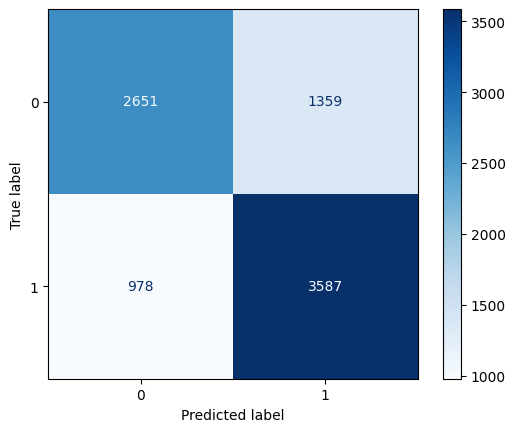

In [36]:
# compute confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(values_format='d', cmap='Blues')

In [37]:
# look at classification report
print(classification_report(y_test, y_pred_classes))

              precision    recall  f1-score   support

           0       0.73      0.66      0.69      4010
           1       0.73      0.79      0.75      4565

    accuracy                           0.73      8575
   macro avg       0.73      0.72      0.72      8575
weighted avg       0.73      0.73      0.73      8575



In [67]:
# save model
best_model.save('randomSearch_AlphabetSoupCharity.keras')

## Bayesian Optimization (with 50 epochs and 30 trials)

In [68]:
# check results summary
tuner.results_summary()

Results summary
Results in hypertuning_results\charity_model
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 06 summary
Hyperparameters:
num_layers: 5
units_0: 128
activation: elu
12_reg: 2.0397530162365785e-05
dropout_0: 0.30000000000000004
units_1: 128
dropout_1: 0.4
units_2: 96
dropout_2: 0.30000000000000004
optimizer: rmsprop
learning_rate: 0.0012104165274262825
units_3: 32
dropout_3: 0.30000000000000004
units_4: 32
dropout_4: 0.2
units_5: 160
dropout_5: 0.30000000000000004
Score: 0.731195330619812

Trial 29 summary
Hyperparameters:
num_layers: 4
units_0: 256
activation: tanh
12_reg: 2.9203812485812294e-05
dropout_0: 0.2
units_1: 128
dropout_1: 0.30000000000000004
units_2: 160
dropout_2: 0.2
optimizer: adam
learning_rate: 0.0021454724811474403
units_3: 192
dropout_3: 0.30000000000000004
units_4: 160
dropout_4: 0.4
units_5: 192
dropout_5: 0.30000000000000004
Score: 0.7308065891265869

Trial 13 summary
Hyperparameters:
num_layers: 6
units_0: 224
activati

In [69]:
# get best model hp's
best_hp = tuner.get_best_hyperparameters()[0]
best_hp.values

{'num_layers': 5,
 'units_0': 128,
 'activation': 'elu',
 '12_reg': 2.0397530162365785e-05,
 'dropout_0': 0.30000000000000004,
 'units_1': 128,
 'dropout_1': 0.4,
 'units_2': 96,
 'dropout_2': 0.30000000000000004,
 'optimizer': 'rmsprop',
 'learning_rate': 0.0012104165274262825,
 'units_3': 32,
 'dropout_3': 0.30000000000000004,
 'units_4': 32,
 'dropout_4': 0.2,
 'units_5': 160,
 'dropout_5': 0.30000000000000004}

In [70]:
# evaluate best model
best_model = tuner.get_best_models()[0]
model_loss, model_accuracy = best_model.evaluate(x_test_processed, y_test, verbose=2)
print(f'Loss: {model_loss}, Accuracy: {model_accuracy}')

c:\Users\brian\anaconda3\envs\tf\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


268/268 - 1s - 5ms/step - accuracy: 0.7282 - loss: 0.5640
Loss: 0.5640073418617249, Accuracy: 0.7281632423400879


In [71]:
# get predictions from the best model to evaluate
y_pred_probs = best_model.predict(x_test_processed)

# convert probabilities to binary predictions (0 or 1)
y_pred_classes = (y_pred_probs > 0.5).astype(int)
y_pred_classes

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [1]])

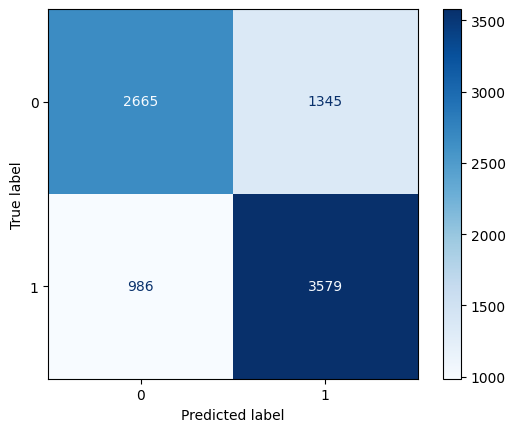

In [72]:
# compute confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(values_format='d', cmap='Blues')

In [73]:
# look at classification report
print(classification_report(y_test, y_pred_classes))

              precision    recall  f1-score   support

           0       0.73      0.66      0.70      4010
           1       0.73      0.78      0.75      4565

    accuracy                           0.73      8575
   macro avg       0.73      0.72      0.73      8575
weighted avg       0.73      0.73      0.73      8575



In [74]:
# save model
best_model.save('bayesian_AlphabetSoupCharity.keras')